<a href="https://colab.research.google.com/github/krauseannelize/project-report-traveltide-rewards/blob/main/notebooks/traveltide_02_users_aggregation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation Analysis | TravelTide Rewards Program

# Part 2: User-Level Aggregation

## 1 - Project Objective

The aim of this project is to support the Head of Marketing at TravelTide in designing a personalized rewards program that increases customer engagement and retention. Using a database of customer profiles, session activity, flight bookings, and hotel reservations, I analyze travel behavior, booking patterns, and discount sensitivity. My role as a Data Analyst is to deliver actionable insights that guide the personalization of perks, ensuring they align with distinct customer preferences.

`Part 2: User‑Level Aggregation` consolidates session data into aggregated customer profiles, enabling the exploration of spending habits, discount responsiveness, and behavioral signals at the individual level. This step builds on the session‑level foundation to uncover broader patterns across users, setting the stage for segmentation modeling in Part 3.

## 2 - Data Import & Initial Inspection

### 2.1 Import Packages & Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import math

# Google Colab integration
from google.colab import drive

# Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [Part 1: Session‑Level Exploration](https://colab.research.google.com/drive/1emYHQyjeZ8BtHN8ljUm6s1gTyDjLxb_T?usp=sharing), the raw sessions dataset was thoroughly cleaned and enriched with additional features. The resulting dataset was exported as `traveltide-sessions-enriched.csv`, providing a reliable foundation for further analysis. In this notebook, I simply reload that enriched dataset and shift the focus from individual sessions to aggregated user profiles.

### 2.2 Load Dataset

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# Read vehicle dataset as pandas DataFrame
enriched_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ms-data/traveltide-sessions-enriched.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2.3 Inspect Dataset

In [3]:
# Confirm vehicle dataset has loaded successfully
enriched_df.head()

,session_id,user_id,trip_id,session_start,session_end,page_clicks,flight_discount,flight_discount_amount,flight_booked,hotel_discount,...,trip_start,trip_start_day,trip_end,trip_end_day,trip_duration_days,effective_flight_fare,effective_hotel_rate,total_hotel_cost,total_trip_cost,trip_distance_km
0,23557-3f6bd6be250e45959b33b808ac525df6,23557,NaN,2023-01-04 19:30:00,2023-01-04 19:33:53,32,False,NaN,False,False,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,120851-bfeb515377f44fdbbb9d9642dc0c7178,120851,NaN,2023-01-04 19:49:00,2023-01-04 19:49:37,5,False,NaN,False,False,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2,229108-d2b0f9bc7aea425189cb943fa1706810,229108,NaN,2023-01-04 20:44:00,2023-01-04 20:45:29,12,True,0.2,False,False,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
3,264470-71e8f4d269aa44308aa34ffd1c2d0c18,264470,NaN,2023-01-04 22:50:00,2023-01-04 22:50:59,8,False,NaN,False,False,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
4,348863-e3c9ba813fc84210a236a3a11e364859,348863,NaN,2023-01-04 08:57:00,2023-01-04 08:58:15,10,False,NaN,False,False,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN


In [4]:
# Inspect shape of sessions dataset
print(f"---DATASET SHAPE---\nRows: {enriched_df.shape[0]}\nColumns: {enriched_df.shape[1]}")

---DATASET SHAPE---
Rows: 48772
Columns: 56


In [5]:
# Review basic information about enriched dataset
enriched_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48772 entries, 0 to 48771
Data columns (total 56 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   session_id                   48772 non-null  object 
 1   user_id                      48772 non-null  int64  
 2   trip_id                      16263 non-null  object 
 3   session_start                48772 non-null  object 
 4   session_end                  48772 non-null  object 
 5   page_clicks                  48772 non-null  int64  
 6   flight_discount              48772 non-null  bool   
 7   flight_discount_amount       8217 non-null   float64
 8   flight_booked                48772 non-null  bool   
 9   hotel_discount               48772 non-null  bool   
 10  hotel_discount_amount        6152 non-null   float64
 11  hotel_booked                 48772 non-null  bool   
 12  cancellation                 48772 non-null  bool   
 13  birthdate       

## 3 - Data Preprocessing

### 3.1 Drop Unused Columns

I begin by dropping columns that no longer add analytical value because their information has already been captured in engineered features such as session duration, trip distance, and user age.

In [6]:
# drop session timestamps (replacement: session_duration_min)
enriched_df.drop(columns=["session_start", "session_end"], inplace=True)

# drop birthdate timestamps (replacement: user_age)
enriched_df.drop(columns=["birthdate"], inplace=True)

# drop individual booking flags (replacement: booking_type)
enriched_df.drop(columns=["flight_booked", "hotel_booked", "return_flight_booked"], inplace=True)

# drop cancellation flag (replacement: booking_status)
enriched_df.drop(columns=["cancellation"], inplace=True)

# drop raw hotel and flight times (replacment: trip_start and trip_end)
enriched_df.drop(columns=["check_in_time", "check_out_time", "departure_time", "return_time"], inplace=True)

# drop trip_start and trip_end (replacement: trip_start_day, trip_end_day, trip_duration_days)
enriched_df.drop(columns=["trip_start", "trip_end"], inplace=True)

# drop location coordinates (replacement: trip_distance_km)
enriched_df.drop(columns=["home_airport_lat", "home_airport_lon", "destination_airport_lat", "destination_airport_lon"], inplace=True)

# drop discount flags (replacement: discount_amount > 0 logic for actual discount counts)
enriched_df.drop(columns=["flight_discount", "hotel_discount"], inplace=True)

### 3.2 Standardize Data Types

In [7]:
# Convert sign_up_date to datetime
enriched_df["sign_up_date"] = pd.to_datetime(enriched_df["sign_up_date"], errors="coerce")

# Confirm conversion
print(enriched_df["sign_up_date"].dtypes)

datetime64[ns]


### 3.3 Feature: `account_age`

In [8]:
# User account age in years (using fixed reference date for consistency)
reference_date = pd.Timestamp("2025-01-01")
enriched_df["account_age"] = (
    (reference_date - enriched_df["sign_up_date"]).dt.days // 365
).round().astype(int)

# Confirm new column creation and view first few rows
enriched_df[["account_age"]].head()

,account_age
0,3
1,2
2,2
3,2
4,2


In [9]:
# Drop sign_up_date as it has been replaced
enriched_df.drop(columns=["sign_up_date"], inplace=True)

In [10]:
enriched_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48772 entries, 0 to 48771
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   session_id                   48772 non-null  object 
 1   user_id                      48772 non-null  int64  
 2   trip_id                      16263 non-null  object 
 3   page_clicks                  48772 non-null  int64  
 4   flight_discount_amount       8217 non-null   float64
 5   hotel_discount_amount        6152 non-null   float64
 6   gender                       48772 non-null  object 
 7   married                      48772 non-null  bool   
 8   has_children                 48772 non-null  bool   
 9   home_country                 48772 non-null  object 
 10  home_city                    48772 non-null  object 
 11  home_airport                 48772 non-null  object 
 12  origin_airport               13831 non-null  object 
 13  destination     

In [11]:
# View flight_discount, flight_discount_amount, hotel_discount, hotel_discount_amount where booking_status is "cancelled"
# and group
enriched_df.loc[enriched_df["booking_status"] == "cancelled"]

,session_id,user_id,trip_id,page_clicks,flight_discount_amount,hotel_discount_amount,gender,married,has_children,home_country,...,booking_status,trip_start_day,trip_end_day,trip_duration_days,effective_flight_fare,effective_hotel_rate,total_hotel_cost,total_trip_cost,trip_distance_km,account_age
32738,498500-4f54c05abc824775937b6a61b322f400,498500,498500-8625a588e269412d9c6ac9ddbbb19a9d,200,NaN,NaN,f,True,True,usa,...,cancelled,Tuesday,Saturday,5,540.88,193.0,579.0,1119.88,2872.14,2
32739,411179-7a66cb2e947147e795e159a30ec350b5,411179,411179-3e79bf8334914815b7dc005dc0ebd89a,200,NaN,NaN,f,False,False,usa,...,cancelled,Thursday,Monday,5,202.92,310.0,1240.0,1442.92,1131.04,2
32740,524448-d8f14d1175764428927818f3c99dd2cf,524448,524448-944c2290892747b5b22b8907d23694be,200,NaN,NaN,f,True,True,canada,...,cancelled,Saturday,Tuesday,4,327.19,167.0,334.0,661.19,1676.58,1
32741,454934-9ab1661e94974d2088cc254093e3212d,454934,454934-2b0809d98c0a466ab8f1502d8c229ffc,66,NaN,NaN,f,True,False,usa,...,cancelled,Monday,Thursday,4,141.89,220.0,440.0,581.89,756.91,2
32742,513807-40598c950fe847dfa2968a2075cac65f,513807,513807-3c80157290d341feac1def60567b019c,200,NaN,NaN,f,True,True,usa,...,cancelled,NaN,NaN,0,903.26,NaN,NaN,NaN,1204.67,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48767,542095-22cca89073d644189eae13fedfb9ff47,542095,542095-da1172e2431342eba39c1630cbf81673,13,NaN,NaN,f,True,True,usa,...,cancelled,Friday,Sunday,10,283.94,218.0,1744.0,2027.94,1650.85,1
48768,614311-2197e666c846476eb4a7816323357507,614311,614311-d21df59cc4ab4640add93d76b450f37c,43,NaN,NaN,f,True,False,usa,...,cancelled,NaN,NaN,0,4912.79,NaN,NaN,NaN,13540.82,1
48769,520947-1082965ab12744069c3a4d3c637ad7e7,520947,520947-83843cd2814a4b48b62399969dfa5c60,43,NaN,NaN,o,True,True,usa,...,cancelled,Thursday,Monday,12,409.10,181.0,1810.0,2219.10,2219.10,1
48770,640689-f021e246e24543b78bae3786ebfe802e,640689,640689-fc78829e4e6a429bb139e27e751090a4,39,NaN,NaN,f,False,False,usa,...,cancelled,Sunday,Monday,9,327.04,149.0,894.0,1221.04,1856.64,1


### 3.4 One-Hot Encoding

Before aggregation, categorical features such as booking_type and booking_status are expanded into dummy columns to ensure that user-level aggregation captures the full distribution of behaviors (counts and proportions) rather than collapsing categories.

In [12]:
# Define categorical columns and their shorter prefixes
categorical_cols = {
    "booking_type": "type",
    "booking_status": "status",
    "trip_start_day": "start",
    "trip_end_day": "end"
}

# One-hot encode with custom prefixes
encoded_df = pd.get_dummies(
    enriched_df
    , columns=categorical_cols.keys()
    , prefix=categorical_cols.values()
)

# Confirm new dummy columns
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48772 entries, 0 to 48771
Data columns (total 56 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   session_id                   48772 non-null  object 
 1   user_id                      48772 non-null  int64  
 2   trip_id                      16263 non-null  object 
 3   page_clicks                  48772 non-null  int64  
 4   flight_discount_amount       8217 non-null   float64
 5   hotel_discount_amount        6152 non-null   float64
 6   gender                       48772 non-null  object 
 7   married                      48772 non-null  bool   
 8   has_children                 48772 non-null  bool   
 9   home_country                 48772 non-null  object 
 10  home_city                    48772 non-null  object 
 11  home_airport                 48772 non-null  object 
 12  origin_airport               13831 non-null  object 
 13  destination     

## 4 - User Aggregation

### 4.1 Data Extraction

In [13]:
# Define one-hot columns
one_hot_cols = [col for col in encoded_df.columns if col.startswith(("type_", "status_", "start_", "end_"))]

user_agg = encoded_df.groupby("user_id").agg(
    # Demographics
    gender=("gender", "first")
    , married=("married", "first")
    , has_children=("has_children", "first")
    , home_country=("home_country", "first")
    , home_city=("home_city", "first")
    , home_airport=("home_airport", "first")
    , user_age=("user_age", "max")
    , account_age=("account_age", "max")

    # Sessions
    , total_sessions=("session_id", "count")
    , avg_session_duration=("session_duration_min", "mean")
    , avg_page_clicks=("page_clicks", "mean")
    , avg_clicks_per_min=("clicks_per_min", "mean")

    # Flights
    , avg_seats=("seats", "mean")
    , avg_checked_bags=("checked_bags", "mean")
    , avg_flight_base_fare=("flight_base_fare_usd", "mean")
    , avg_flight_paid_fare=("effective_flight_fare", "mean")
    , num_flight_discounts=("flight_discount_amount", lambda x: (x > 0).sum())
    , avg_flight_discount_amount=("flight_discount_amount", lambda x: x[x > 0].mean())
    , total_airlines=("trip_airline", "nunique")
    , total_origin_airports=("origin_airport", "nunique")
    , total_destinations=("destination", "nunique")
    , total_destination_airports=("destination_airport", "nunique")

    # Hotels
    , avg_nights=("nights", "mean")
    , avg_rooms=("rooms", "mean")
    , avg_hotel_base_rate=("hotel_base_nightly_rate_usd", "mean")
    , avg_hotel_paid_rate=("effective_hotel_rate", "mean")
    , avg_total_hotel_cost=("total_hotel_cost", "mean")
    , num_hotel_discounts=("hotel_discount_amount", lambda x: (x > 0).sum())
    , avg_hotel_discount_amount=("hotel_discount_amount", lambda x: x[x > 0].mean())
    , total_hotels=("hotel_name", "nunique")

    # Trips
    , total_trips=("trip_id", "count")
    , avg_trip_duration_days=("trip_duration_days", "mean")
    , avg_total_trip_cost=("total_trip_cost", "mean")
    , avg_trip_distance_km=("trip_distance_km", "mean")
).reset_index()

# Add one-hot sums
user_agg[one_hot_cols] = encoded_df.groupby("user_id")[one_hot_cols].sum().reset_index(drop=True)


### 4.2 Data Inspection

In [14]:
# Inspect shape of sessions dataset
print(f"---DATASET SHAPE---\nRows: {user_agg.shape[0]}\nColumns: {user_agg.shape[1]}")

---DATASET SHAPE---
Rows: 5998
Columns: 58


In [15]:
# Preview user aggregated dataset
user_agg.head()

,user_id,gender,married,has_children,home_country,home_city,home_airport,user_age,account_age,total_sessions,...,start_Thursday,start_Tuesday,start_Wednesday,end_Friday,end_Monday,end_Saturday,end_Sunday,end_Thursday,end_Tuesday,end_Wednesday
0,23557,f,True,False,usa,new york,lga,66,3,8,...,1,1,0,0,0,2,0,0,0,0
1,94883,f,True,False,usa,kansas city,mci,52,2,8,...,0,0,0,0,1,0,0,0,0,1
2,101486,f,True,True,usa,tacoma,tcm,52,2,8,...,0,0,0,0,0,0,0,1,0,1
3,101961,f,True,False,usa,boston,bos,44,2,8,...,1,1,1,0,2,0,0,0,2,1
4,106907,f,True,True,usa,miami,tnt,46,2,8,...,0,2,0,0,2,0,0,0,0,0


In [16]:
# Review basic information about sessions dataset
user_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5998 entries, 0 to 5997
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     5998 non-null   int64  
 1   gender                      5998 non-null   object 
 2   married                     5998 non-null   bool   
 3   has_children                5998 non-null   bool   
 4   home_country                5998 non-null   object 
 5   home_city                   5998 non-null   object 
 6   home_airport                5998 non-null   object 
 7   user_age                    5998 non-null   int64  
 8   account_age                 5998 non-null   int64  
 9   total_sessions              5998 non-null   int64  
 10  avg_session_duration        5998 non-null   float64
 11  avg_page_clicks             5998 non-null   float64
 12  avg_clicks_per_min          5998 non-null   float64
 13  avg_seats                   5998 

In [17]:
# Count no duplicate rows
print(f"Number of duplicate rows: {user_agg.duplicated().sum()}")

Number of duplicate rows: 0


In [18]:
# Count missing values per column
user_agg.isna().sum().sort_values(ascending=False)

,0
avg_hotel_discount_amount,2006
avg_flight_discount_amount,1343
avg_total_trip_cost,1107
avg_trip_distance_km,852
avg_flight_base_fare,852
avg_flight_paid_fare,852
avg_total_hotel_cost,629
avg_hotel_base_rate,629
avg_hotel_paid_rate,629
home_country,0


### 4.3 Export User Aggregation

In [19]:
# Export user aggregation dataset to .csv to reuse
user_agg.to_csv('/content/drive/MyDrive/Colab Notebooks/ms-data/traveltide-user_aggregation.csv', index=False)

### 4.4 Data Visualization

#### 4.4.1 User Behavior by Age Group and Family Status

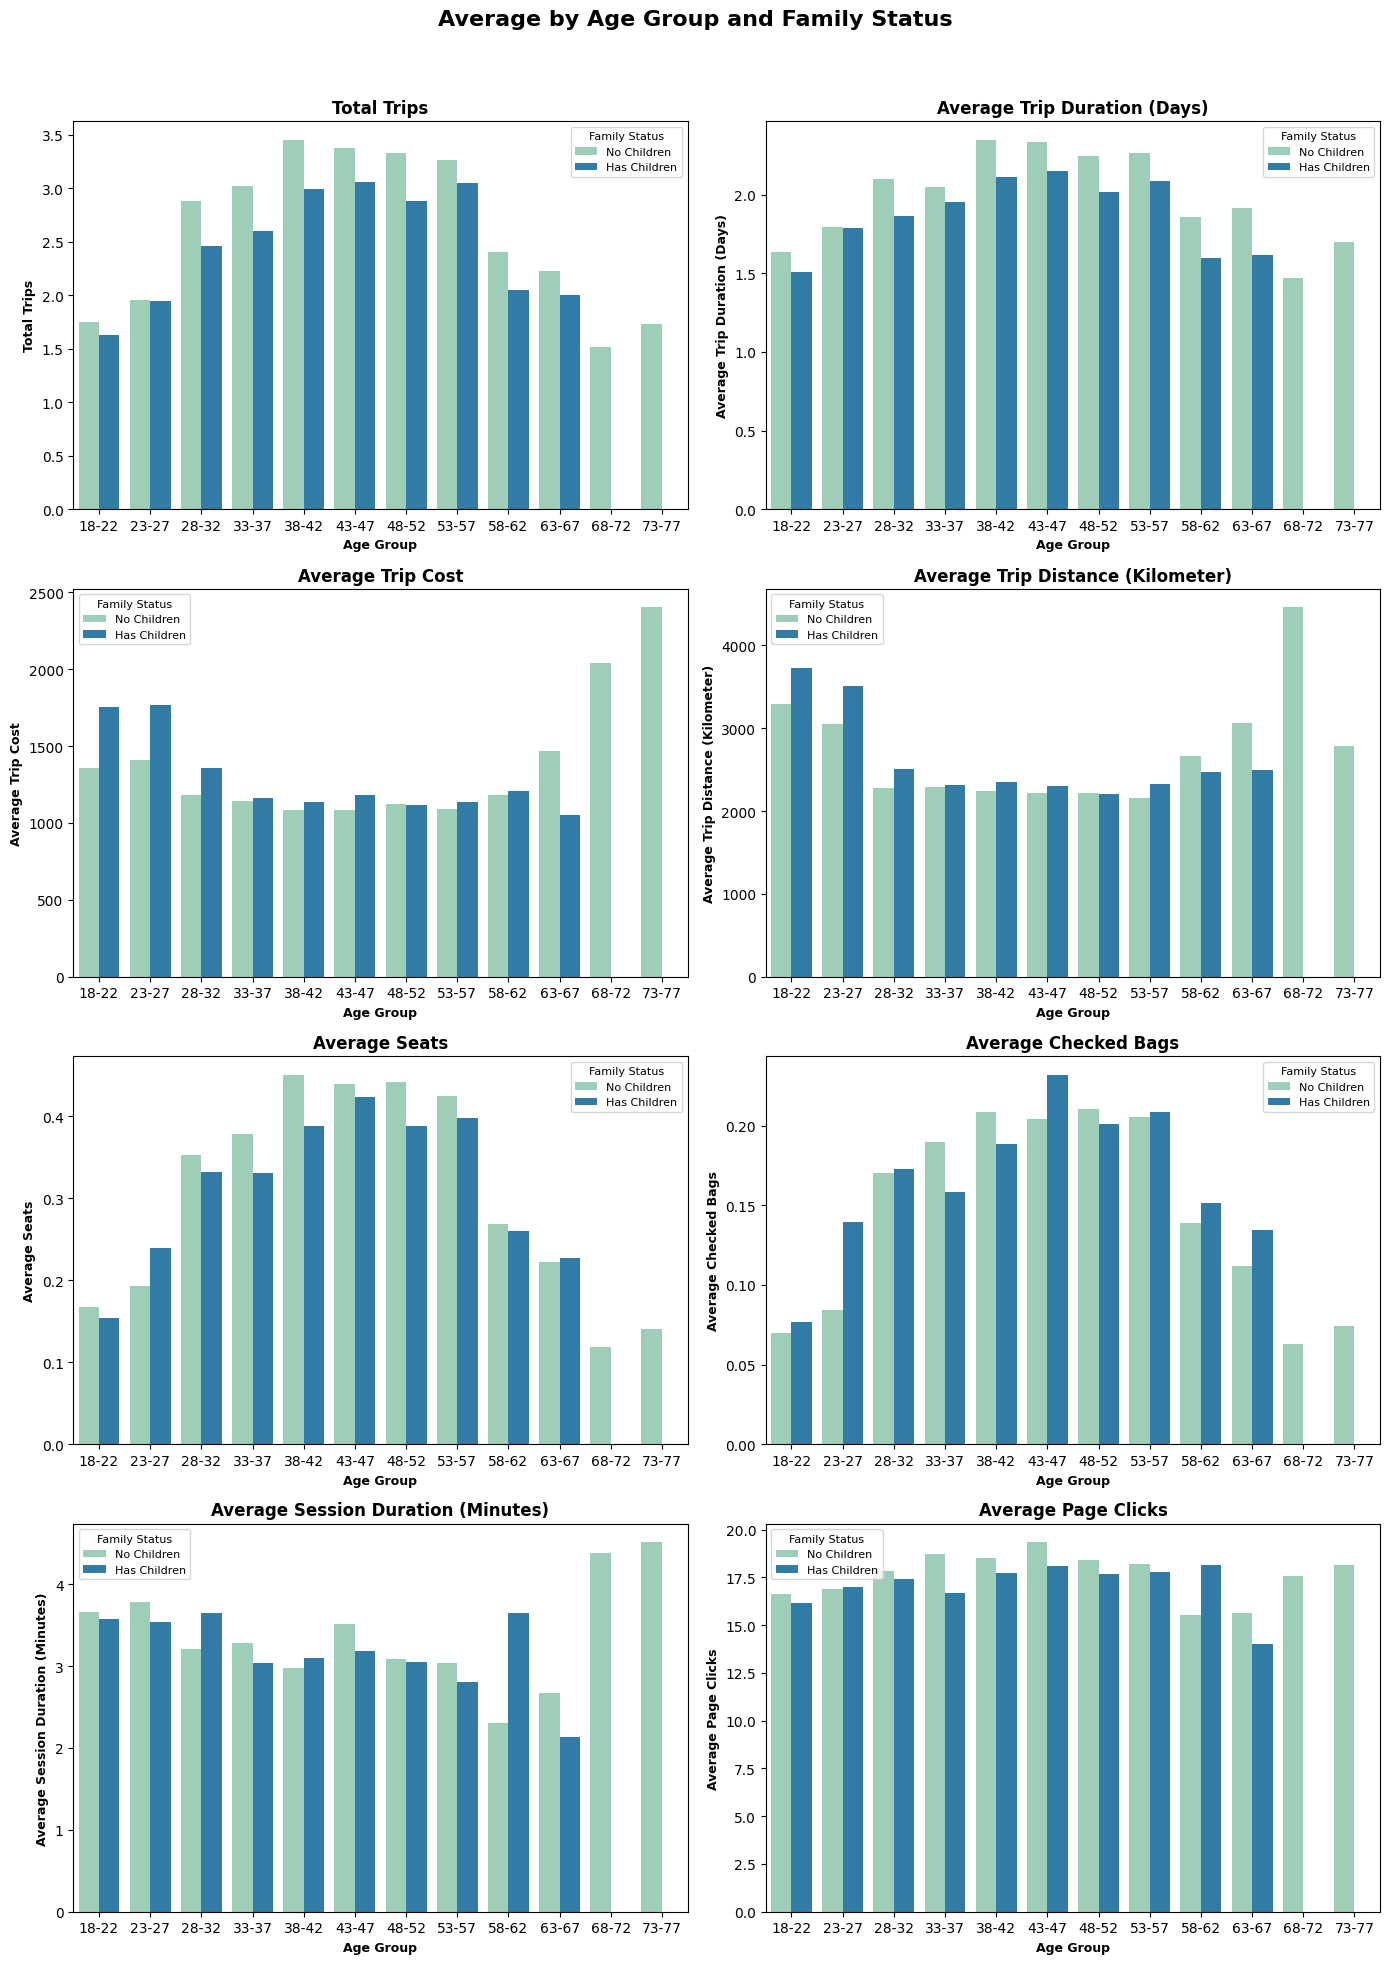

In [20]:
# Create filtered dataset to visualize age groups
age_groups = user_agg[user_agg["total_trips"] > 0].copy()

# Bin ages into groups for readability
age_bins = list(range(18, 81, 5))  # [18, 23, 28, ..., 78]
age_labels = [f"{age_bins[i]}-{age_bins[i+1]-1}" for i in range(len(age_bins)-1)]
age_groups["age_group"] = pd.cut(
    age_groups["user_age"]
    , bins=age_bins
    , labels=age_labels
    , right=False
)

# Change boolean labels for readability
age_groups["has_children_label"] = age_groups["has_children"].map({True: "Has Children", False: "No Children"})

# Function to create a barplot of user age group distribution and family status
def plot_user_groups(df, col, label, ax):
    sns.barplot(
        data=df
        , x="age_group"
        , y=col
        , hue="has_children_label"
        , palette="YlGnBu"
        , estimator="mean"
        , errorbar=None
        , ax=ax
    )
    ax.set_title(label, fontsize=12, fontweight="bold")
    ax.set_xlabel("Age Group", fontsize=9, fontweight="bold")
    ax.set_ylabel(label, fontsize=9, fontweight="bold")
    ax.legend(title="Family Status", title_fontsize=8, fontsize=8)

# Columns to iterate over with improved labels
cols_age_compare = {
    "total_trips": "Total Trips"
    , "avg_trip_duration_days": "Average Trip Duration (Days)"
    , "avg_total_trip_cost": "Average Trip Cost"
    , "avg_trip_distance_km": "Average Trip Distance (Kilometer)"
    , "avg_seats": "Average Seats"
    , "avg_checked_bags": "Average Checked Bags"
    , "avg_session_duration": "Average Session Duration (Minutes)"
    , "avg_page_clicks": "Average Page Clicks"
}

# Set plot figure with subplots (4 rows × 2 cols = 8 plots)
fig, axes = plt.subplots(4, 2, figsize=(14, 20))
axes = axes.flatten()

# Create a barplot for each variable
for i, (col, label) in enumerate(cols_age_compare.items()):
    plot_user_groups(age_groups, col, label, axes[i])

# Display plot
plt.suptitle("Average by Age Group and Family Status", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Travel behavior and engagement vary clearly across age groups, with mid‑life users (mid‑30s to mid‑50s) showing the highest trip frequency, longer durations, shorter‑haul travel, and steadier cost levels compared to younger and older cohorts. Across most age ranges, users without children generally book more trips and stay longer, though differences in distance and spend vary by segment. Younger travelers (18–27) take fewer, shorter trips with higher average costs, while older users (63+) travel less often but show higher per‑trip expenses, longer browsing sessions, and greater travel distances. Overall, family status shapes behavior incrementally, with non‑family users tending toward more trips, longer stays, and slightly higher engagement.

#### 4.4.2 Distribution of Trip Duration

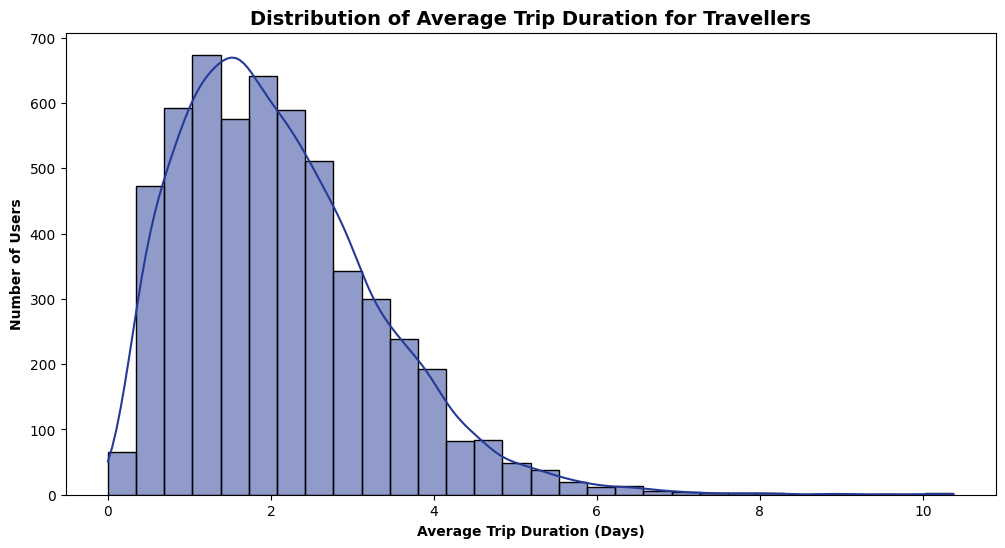

In [21]:
# Keep only users who have taken trips
filtered = user_agg[user_agg["total_trips"] > 0]

# Set up plot
plt.figure(figsize=(12, 6))

# Create a histogram
sns.histplot(
    filtered["avg_trip_duration_days"]
    , bins=30
    , kde=True
    , color="#253997"
    )

# Add labels and title
plt.title("Distribution of Average Trip Duration for Travellers", fontsize=14, fontweight="bold")
plt.xlabel("Average Trip Duration (Days)", fontsize=10, fontweight="bold")
plt.ylabel("Number of Users", fontsize=10, fontweight="bold")
plt.show()

Most travellers take short trips, with the majority averaging between 1 and 3 days. Extended travel beyond a week is uncommon, underscoring that quick getaways dominate user behaviour.

#### 4.4.3 Average Discount Amount by Age

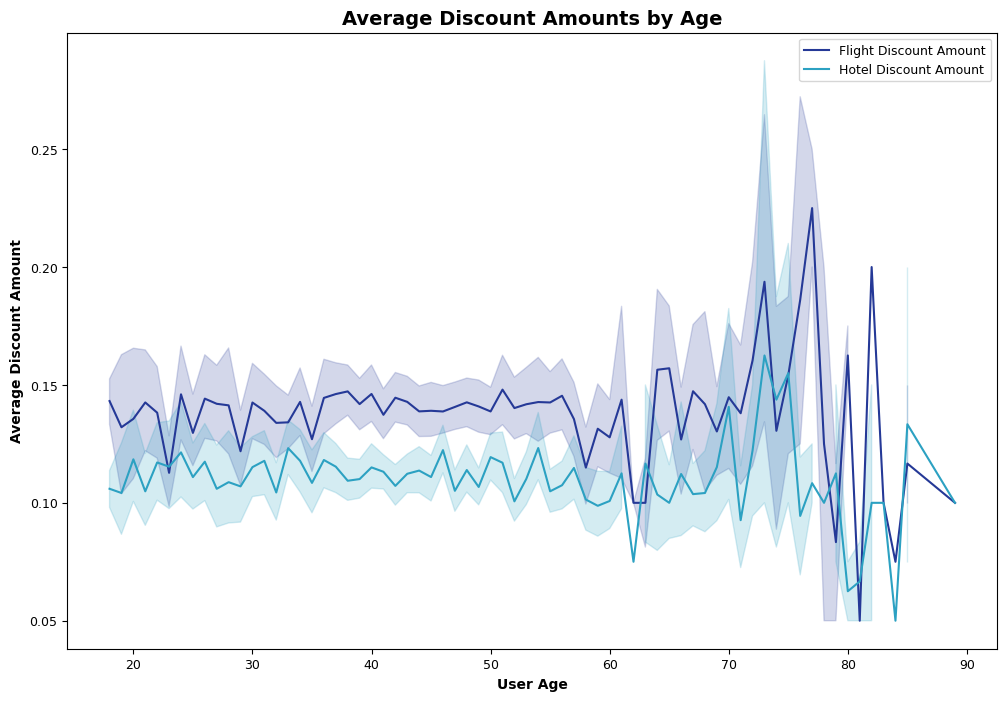

In [22]:
# Filter out zero discounts
hotel_filtered = user_agg[user_agg["avg_hotel_discount_amount"] > 0]
flight_filtered = user_agg[user_agg["avg_flight_discount_amount"] > 0]

# Set plot figure
plt.figure(figsize=(12,8))

# Line 1: Flight discount amounts
sns.lineplot(
    data=flight_filtered,
    x="user_age",
    y="avg_flight_discount_amount",
    label="Flight Discount Amount",
    color="#253997"
)

# Line 2: Hotel discount amounts
sns.lineplot(
    data=hotel_filtered,
    x="user_age",
    y="avg_hotel_discount_amount",
    label="Hotel Discount Amount",
    color="#2ca1c2"
)

# Add title and labels
plt.title("Average Discount Amounts by Age", fontsize=14, fontweight="bold")
plt.xlabel("User Age", fontsize=10, fontweight="bold")
plt.ylabel("Average Discount Amount", fontsize=10, fontweight="bold")
plt.tick_params(axis='both', which='major', labelsize=9)
plt.legend(fontsize=9)
plt.show()

Average discount amounts for both hotels and flights track closely across age, with the hotel line consistently lower than the flight line, echoing the sensitivity pattern noted in Part 1. From ages 18 to the mid‑50s, both measures remain stable within a narrow band (0.1–0.15), indicating consistent discount behavior among younger and mid‑life users. Around age 65, discount amounts rise, peaking in the late 70s with values approaching 0.25, before declining again in the oldest cohorts. The heavy overlap of the two lines and their confidence intervals shows that differences between hotel and flight discounts are not statistically distinct across most age ranges, producing a clustered appearance. The fading of confidence bands after age 75 reflects fewer observations and smaller sample sizes, rather than a clear behavioral shift.

## 5 - Summary and Next Steps

Key insights from the user‑level aggregation include:

- Mid‑life users travel most frequently and steadily, while younger cohorts take fewer, shorter, costlier trips and older cohorts travel less often but spend more per trip. Family status shapes behavior incrementally, with non‑family users tending to book more and stay longer.
- The majority of users favor short getaways of one to three days, underscoring that quick trips dominate travel behavior, while extended journeys beyond a week remain rare.
- Hotel and flight discounts move in lockstep across age, with only modest variation. Discount amounts rise in later life stages, peaking in the late 70s, though smaller sample sizes make these results less conclusive.

Together, these findings show how aggregated user profiles reveal demographic and behavioral patterns beyond session‑level data. Extending this analysis, [Part 3: Customer Segmentation](https://colab.research.google.com/drive/1oZgUapacdOPs7ytsXTxanwbvEXpWCIKP?usp=sharing) focuses on customer segmentation, combining these signals to identify distinct groups and actionable strategies.